# Fashion Mnist DNN Tutorial [CNN & Multi-layer Perceptron (MLP)]

## 외부 파일 가져오기 & requirements 설치

In [1]:
import os
import sys
from datetime import datetime

drive_project_root = "/home/jmj3047/mj_CNN_prac"
sys.path.append(drive_project_root)

In [2]:
gpu_info = !nvidia-smi
gpu_info = "\n".join(gpu_info)
print(gpu_info)

Mon May  2 14:32:27 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA TITAN Xp     Off  | 00000000:18:00.0 Off |                  N/A |
| 23%   28C    P8     8W / 250W |    909MiB / 12288MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA TITAN Xp     Off  | 00000000:3B:00.0 Off |                  N/A |
| 41%   

In [ ]:
!pip install -r "/home/jmj3047/mj_CNN_prac/requirements.txt"

In [3]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch import optim
from torch_optimizer import RAdam
from torch_optimizer import AdamP

from torch.utils.tensorboard import SummaryWriter
from torchvision.datasets import FashionMNIST
from torchvision import transforms

import wandb
from efficientnet_pytorch import EfficientNet

In [4]:
from data_utils import dataset_split

In [5]:
#!pwd
data_root = os.path.join(os.getcwd(), 'data')

#preprocessing & 데이터 셋 정의
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize([0.5],[0.5]) #mean, std
    ]
)

fashion_mnist_dataset = FashionMNIST(data_root, download=True, train=True, transform=transform)

## Dataloader를 정의

In [6]:
from torch.utils.data import random_split
from data_utils import dataset_split

In [7]:
datasets= dataset_split(fashion_mnist_dataset, split=[0.9,0.1])

train_dataset = datasets['train']
val_dataset = datasets['val']

train_batch_size = 100
val_batch_size = 10

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size = train_batch_size, shuffle=True, num_workers=1
)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size = val_batch_size, shuffle=True, num_workers=1
)

In [8]:
for sample_batch in train_dataloader:
    print(sample_batch[0].shape, sample_batch[1].shape)
    break

#torch.Size([100, 1, 28, 28]) batchsize, channel, width, height

torch.Size([100, 1, 28, 28]) torch.Size([100])


## 모델 (Multi-layer Perceptron) (MLP) ! 정의
## 모델 MLPWithDropout 정의


In [9]:
import torch. nn.functional as F

In [10]:
#Define Model

class MLP(nn.Module):
    def __init__(self, in_dim=int, h1_dim = int, h2_dim = int, out_dim = int):
        super().__init__()
        self.linear1 = nn.Linear(in_dim, h1_dim)
        self.linear2 = nn.Linear(h1_dim, h2_dim)
        self.linear3 = nn.Linear(h2_dim, out_dim)
        self.relu = F.relu #activation 함수 정의

        pass

    def forward(self, input):
        x = torch.flatten(input, start_dim=1)
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        out = self.linear3(x)
        out = F.sigmoid(out) #binary classification은 softmax로 사용
        return out



class MLPWithDropout(MLP):
    def __init__(self, in_dim: int, h1_dim: int, h2_dim: int, out_dim: int, dropout_prob: float):
        super().__init__(in_dim, h1_dim, h2_dim, out_dim)
        self.dropout1 = nn.Dropout(dropout_prob)
        self.dropout2 = nn.Dropout(dropout_prob)
    
    def forward(self, input):
        x = torch.flatten(input, start_dim=1)
        x = self.relu(self.linear1(x))
        x = self.dropout1(x)
        x = self.relu(self.linear2(x))
        x = self.dropout2(x)
        out = self.linear3(x)
        # out = F.softmax(out)
        return out

## CNN 모델 정의

In [11]:
from omegaconf import OmegaConf #하이퍼파라미터를 관리하기 위한 오픈소스 라이브러리
from omegaconf import DictConfig

In [21]:
_cnn_cfg_dict: dict = {
    "layer_1": {
        "conv2d_in_channels": 1,
        "conv2d_out_channels": 32,  
        "conv2d_kernel_size": 3,
        "conv2d_padding": 1,
        "maxpool2d_kernel_size": 2,
        "maxpool2d_stride": 2,
    },
    "layer_2": {
        "conv2d_in_channels": 32,
        "conv2d_out_channels": 64,
        "conv2d_kernel_size": 3,
        "conv2d_padding": 0,
        "maxpool2d_kernel_size": 2,
        "maxpool2d_stride": 1,
    },
    "fc_1": {
        "in_features": 7744, #  수정 필요!
        "out_features": 512,
    },
    "fc_2": {
        "in_features": 512,
        "out_features": 128,        
    },
    "fc_3": {
        "in_features": 128,
        "out_features": 10,
    },
    "dropout_prob": 0.25,
}
_cnn_cfg = OmegaConf.create(_cnn_cfg_dict)
print(OmegaConf.to_yaml(_cnn_cfg))
# #하이퍼 파라미터 저장하고 다시 로드
# with open("cnn_test.yaml","w") as file:
#     OmegaConf.save(_cnn_cfg, file)
# OmegaConf.load

class CNN(nn.Module):
    def __init__(self, cfg: DictConfig = _cnn_cfg):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(
                in_channels=cfg.layer_1.conv2d_in_channels,
                out_channels=cfg.layer_1.conv2d_out_channels,
                kernel_size=cfg.layer_1.conv2d_kernel_size,
                padding=cfg.layer_1.conv2d_padding
            ),
            nn.BatchNorm2d(cfg.layer_1.conv2d_out_channels),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=cfg.layer_1.maxpool2d_kernel_size,
                stride=cfg.layer_1.maxpool2d_stride
            )
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(
                in_channels=cfg.layer_2.conv2d_in_channels,
                out_channels=cfg.layer_2.conv2d_out_channels,
                kernel_size=cfg.layer_2.conv2d_kernel_size,
                padding=cfg.layer_2.conv2d_padding
            ),
            nn.BatchNorm2d(cfg.layer_2.conv2d_out_channels),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=cfg.layer_2.maxpool2d_kernel_size,
                stride=cfg.layer_2.maxpool2d_stride
            )
        )
        self.fc1 = nn.Linear(
            in_features=cfg.fc_1.in_features,
            out_features=cfg.fc_1.out_features,
        )
        self.fc2 = nn.Linear(
            in_features=cfg.fc_2.in_features,
            out_features=cfg.fc_2.out_features,
        )
        self.fc3 = nn.Linear(
            in_features=cfg.fc_3.in_features,
            out_features=cfg.fc_3.out_features,
        )
        self.dropout = nn.Dropout2d(cfg.dropout_prob)


    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1) #flatten작업(batchsize가 0, -1은 앞의 배치 사이즈를 놔두고 나머지만 flat하겠다)
        out = self.fc1(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out


layer_1:
  conv2d_in_channels: 1
  conv2d_out_channels: 32
  conv2d_kernel_size: 3
  conv2d_padding: 1
  maxpool2d_kernel_size: 2
  maxpool2d_stride: 2
layer_2:
  conv2d_in_channels: 32
  conv2d_out_channels: 64
  conv2d_kernel_size: 3
  conv2d_padding: 0
  maxpool2d_kernel_size: 2
  maxpool2d_stride: 1
fc_1:
  in_features: 7744
  out_features: 512
fc_2:
  in_features: 512
  out_features: 128
fc_3:
  in_features: 128
  out_features: 10
dropout_prob: 0.25



In [ ]:
_cnn_cfg_dict: dict = {
    "layer_1": {
        "conv2d_in_channels": 1,
        "conv2d_out_channels": 32,  
        "conv2d_kernel_size": 3,
        "conv2d_padding": 1,
        "maxpool2d_kernel_size": 2,
        "maxpool2d_stride": 2,
    },
    "layer_2": {
        "conv2d_in_channels": 32,
        "conv2d_out_channels": 64,
        "conv2d_kernel_size": 3,
        "conv2d_padding": 0,
        "maxpool2d_kernel_size": 2,
        "maxpool2d_stride": 1,
    },
    "fc_1": {
        "in_features": 7744, #  수정 필요!
        "out_features": 512,
    },
    "fc_2": {
        "in_features": 512,
        "out_features": 128,        
    },
    "fc_3": {
        "in_features": 128,
        "out_features": 10,
    },
    "dropout_prob": 0.25,
}
_cnn_cfg = OmegaConf.create(_cnn_cfg_dict)
print(OmegaConf.to_yaml(_cnn_cfg))
# #하이퍼 파라미터 저장하고 다시 로드
# with open("cnn_test.yaml","w") as file:
#     OmegaConf.save(_cnn_cfg, file)
# OmegaConf.load

class CNN(nn.Module):
    def __init__(self, cfg: DictConfig = _cnn_cfg):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(
                in_channels=cfg.layer_1.conv2d_in_channels,
                out_channels=cfg.layer_1.conv2d_out_channels,
                kernel_size=cfg.layer_1.conv2d_kernel_size,
                padding=cfg.layer_1.conv2d_padding
            ),
            nn.BatchNorm2d(cfg.layer_1.conv2d_out_channels),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=cfg.layer_1.maxpool2d_kernel_size,
                stride=cfg.layer_1.maxpool2d_stride
            )
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(
                in_channels=cfg.layer_2.conv2d_in_channels,
                out_channels=cfg.layer_2.conv2d_out_channels,
                kernel_size=cfg.layer_2.conv2d_kernel_size,
                padding=cfg.layer_2.conv2d_padding
            ),
            nn.BatchNorm2d(cfg.layer_2.conv2d_out_channels),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=cfg.layer_2.maxpool2d_kernel_size,
                stride=cfg.layer_2.maxpool2d_stride
            )
        )
        self.fc1 = nn.Linear(
            in_features=cfg.fc_1.in_features,
            out_features=cfg.fc_1.out_features,
        )
        self.fc2 = nn.Linear(
            in_features=cfg.fc_2.in_features,
            out_features=cfg.fc_2.out_features,
        )
        self.fc3 = nn.Linear(
            in_features=cfg.fc_3.in_features,
            out_features=cfg.fc_3.out_features,
        )
        self.dropout = nn.Dropout2d(cfg.dropout_prob)


    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1) #flatten작업(batchsize가 0, -1은 앞의 배치 사이즈를 놔두고 나머지만 flat하겠다)
        out = self.fc1(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out


## Learning Rate Scheduler 



In [27]:
#Warmup Scheduler
class WarmupLR(optim.lr_scheduler.LambdaLR):
    def __init__(self, optimpizer:optim.Optimizer, warmup_end_stops:int, last_epoch:int = -1):
        def warmup_fn(step:int):
            if step < warmup_end_stops:
                return float(step)/float(max(warmup_end_stops,1))
            return 1.0
        
        super().__init__(optimizer, warmup_fn, last_epoch)

## 모델 선언 및 손실 함수, 최적화(Optimizer) 정의, Tensorboard Logger 정의 

In [35]:
#gpu setup
# gpu = None
gpu = 0

#define model
# model = MLP(28*28, 128, 64, 10)
# model = MLPWithDropout(28*28, 128,64,10, dropout_prob=0.3)

model = CNN(cfg=_cnn_cfg)
if gpu is not None:
    model.cuda(gpu)
model_name = type(model).__name__
print(model_name)

#define loss
loss_function = nn.CrossEntropyLoss()

#define optimizer
lr=1e-3
optimizer = torch.optim.RAdam(model.parameters(), lr=lr)
# optimizer = torch.optim.SGD(model.parameters(), lr=lr)
# optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# optimizer = torch.optim.AdamP(model.parameters(), lr=lr)
optimizer_name = type(optimizer).__name__


#define scheduler
# scheduler = None
scheduler = WarmupLR(optimizer, 1500)
scheduler_name = type(scheduler).__name__ if scheduler is not None else "no"

max_epoch = 10

#define tensorboard logger
run_name = f"{datetime.now().isoformat(timespec='seconds')}-{model_name}-{optimizer_name}_optim_{lr}_lr_with_{scheduler_name}_scheduler"
run_dirname = "dnn-tutorial-fashion-mnist-runs"
log_dir = os.path.join(drive_project_root, "runs", run_dirname, run_name)
writer = SummaryWriter(log_dir=log_dir)
# writer = SummaryWriter()
log_interval =100

#define wandb
project_name='fastcapmus_fashion_mnist_tutorials'
run_tags = [project_name]
wandb.init(
    project=project_name,
    name=run_name,
    tags=run_tags,
    config={"lr":lr, "model_name":model_name, "optimizer_name":optimizer_name, "scheduler_name": scheduler_name},
    reinit=True
)
wandb.watch(model)

# set save model path
log_model_path = os.path.join(log_dir, "models")
os.makedirs(log_model_path, exist_ok=True)


CNN


Acc/train,▁▅▆▅▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██▇▇▇█▇██▇▇▇██▇██▇██
Acc/val,▁▇████████
Learning Rate,▁▁▂▂▃▄▄▅▅▆▇▇████████████████████████████
Loss/train,█▇▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▂▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁
Loss/val,█▂▁▁▁▁▁▁▁▁
Acc/train,1.0
Acc/val,0.90783
Learning Rate,0.001
Loss/train,0.00044
Loss/val,0.02879


In [29]:
# for i in range(250):
#     print("step", i)
#     optimizer.step()
#     scheduler.step()
#     print(scheduler.get_last_lr())


## Early Stopping callback Object Class 정의

In [33]:
# With some modifications, source is from https://github.com/Bjarten/early-stopping-pytorch

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.ckpt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.ckpt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None: #loss가 최소화 됐을때 save_checkpoint를 저장함
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta: #모델 성능이 더이상 개선되지 않는다 했을 때 early stopping이 됨
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience: #개선이 안됐다고 바로 하는게 아니라 조금 기다렸다가 stop함
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        
        filename = self.path.split('/')[-1]
        save_dir = os.path.dirname(self.path)
        torch.save(model, os.path.join(save_dir, f"val_loss-{val_loss}-{filename}")) #어떤 score에서 멈췄는지가 중요하기 때문에 그걸 print해줌
        self.val_loss_min = val_loss

In [36]:
%load_ext tensorboard
%tensorboard --logdir \home/jmj3047/mj_CNN_prac/runs/dnn-tutorial-fashion-mnist-runs/ #여기다가 log를 쌓을거고 거기 있는걸 plot해달라는 의미

#define EarlyStopping
early_stopper = EarlyStopping(
    patience=3, verbose=True, path = os.path.join(log_model_path, "model.ckpt")
)

#do train with validation
train_step = 0
for epoch in range(1, max_epoch+1):
    #validation step
    with torch.no_grad(): # optimizer가 업데이트 하면 안됨
        val_loss = 0.0
        val_corrects = 0
        model.eval()

        for val_batch_idx, (val_images, val_labels) in enumerate(
            tqdm(val_dataloader, position=0, leave=True, desc = 'validation')
        ):
            if gpu is not None:
                val_images = val_images.cuda(gpu)
                val_labels = val_labels.cuda(gpu)
            #forward
            val_outputs = model(val_images)
            _, val_preds = torch.max(val_outputs, 1)
            
            #loss & acc
            val_loss += loss_function(val_outputs, val_labels) / val_outputs.shape[0] #이게 batch size. batch size만큼 평균을 내겠다는 뜻
            val_corrects += torch.sum(val_preds == val_labels.data) / val_outputs.shape[0]
        
        #valid step logging
        val_epoch_loss = val_loss / len(val_dataloader)
        val_epoch_acc = val_corrects/len(val_dataloader)
        print(
            f"{epoch} epoch, {train_step} step: val_loss: {val_epoch_loss}, val_acc: {val_epoch_acc}" 
        )

        #tensorboard log
        writer.add_scalar("Loss/val", val_epoch_loss, train_step)
        writer.add_scalar("Acc/val", val_epoch_acc, train_step)
        writer.add_images("Images/val", val_images, train_step)

        #wandb log
        wandb.log({
            "Loss/val":val_epoch_loss,
            "Acc/val": val_epoch_acc,
            "Images/val": wandb.Image(val_images),
            "Outputs/val": wandb.Histogram(val_outputs.detach().cpu().numpy()),
            "Preds/val": wandb.Histogram(val_preds.detach().cpu().numpy()),
            "Labels/val": wandb.Histogram(val_labels.data.detach().cpu().numpy()),
        }, step=train_step)

        # check early stopping point & save model if model reached the best performance
        early_stopper(val_epoch_loss, model)
        if early_stopper.early_stop:
            break
        
        #train step
        current_loss = 0
        current_corrects = 0
        model
                



    #train step
    for batch_idx, (images, labels) in enumerate(
         tqdm(train_dataloader, position=0, leave=True, desc = 'train')
    ):
        if gpu is not None:
            images = images.cuda(gpu)
            labels = labels.cuda(gpu)

        #forward        
        current_loss = 0.0
        current_corrects = 0

        #get predictions
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        # print(outputs)
        # print(preds)
        
        #get loss
        loss = loss_function(outputs, labels)


        ###### 여기까지가 forward ###

        #Backpropagation

        #optimitizer 초기화(zero화)
        optimizer.zero_grad()

        #perform backward pass
        loss.backward()

        #perfrom optimization
        optimizer.step()

        #Perform LR Scheduler work
        if scheduler is not None:
            scheduler.step()

        current_loss +=loss.item()
        current_corrects += torch.sum(preds == labels.data)

        if train_step % log_interval == 0:
            train_loss = current_loss / log_interval
            train_acc = current_corrects/log_interval
            print(
                f"{train_step}: train_loss: {train_loss}, train_acc: {train_acc}" 
            )

            #tensorboard log
            writer.add_scalar("Loss/train", train_step)
            writer.add_scalar("Acc/train", train_step)
            writer.add_images("Images/train", images, train_step)
            writer.add_scalar("Learning Rate", scheduler.get_last_lr()[0],train_step)
            writer.add_graph(model, images)
            
            
            # wandb log
            wandb.log({
                "Loss/train": train_loss,
                "Acc/train": train_acc,
                "Images/train": wandb.Image(images),
                "Outputs/train": wandb.Histogram(outputs.detach().cpu().numpy()),
                "Preds/train": wandb.Histogram(preds.detach().cpu().numpy()),
                "Labels/train": wandb.Histogram(labels.data.detach().cpu().numpy()),
                "Learning Rate": scheduler.get_last_lr()[0], 
            }, step=train_step)

            current_loss = 0
            current_corrects = 0

        train_step += 1

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


validation:   0%|          | 0/600 [00:00<?, ?it/s]/home/jmj3047/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1320: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
train:   0%|          | 0/540 [00:00<?, ?it/s]

1 epoch, 0 step: val_loss: 0.2308683544397354, val_acc: 0.09549988061189651
Validation loss decreased (inf --> 0.230868).  Saving model ...
0: train_loss: 0.023066751956939698, train_acc: 0.08999999612569809


train:  19%|█▊        | 100/540 [00:02<00:08, 49.28it/s]

100: train_loss: 0.020549707412719727, train_acc: 0.550000011920929


train:  37%|███▋      | 199/540 [00:05<00:07, 45.08it/s]

200: train_loss: 0.00657417356967926, train_acc: 0.7799999713897705


train:  56%|█████▌    | 300/540 [00:07<00:05, 45.29it/s]

300: train_loss: 0.005445158481597901, train_acc: 0.7899999618530273


train:  74%|███████▍  | 400/540 [00:09<00:02, 50.05it/s]

400: train_loss: 0.0048419606685638425, train_acc: 0.8100000023841858


train:  92%|█████████▏| 498/540 [00:12<00:00, 47.78it/s]

500: train_loss: 0.004596718251705169, train_acc: 0.8399999737739563


train:   0%|          | 0/540 [00:00<?, ?it/s]

2 epoch, 540 step: val_loss: 0.0458122119307518, val_acc: 0.8303320407867432
Validation loss decreased (0.230868 --> 0.045812).  Saving model ...


train:  10%|█         | 55/540 [00:01<00:08, 56.32it/s]

600: train_loss: 0.004506122469902039, train_acc: 0.8499999642372131


train:  29%|██▉       | 156/540 [00:03<00:07, 48.38it/s]

700: train_loss: 0.004101943075656891, train_acc: 0.8799999952316284


train:  47%|████▋     | 256/540 [00:06<00:06, 47.15it/s]

800: train_loss: 0.0028652897477149963, train_acc: 0.8799999952316284


train:  66%|██████▋   | 359/540 [00:08<00:03, 46.74it/s]

900: train_loss: 0.002709656059741974, train_acc: 0.9300000071525574


train:  85%|████████▍ | 458/540 [00:10<00:01, 41.26it/s]

1000: train_loss: 0.002713610827922821, train_acc: 0.9199999570846558


train:   0%|          | 0/540 [00:00<?, ?it/s]

3 epoch, 1080 step: val_loss: 0.033912625163793564, val_acc: 0.8769978284835815
Validation loss decreased (0.045812 --> 0.033913).  Saving model ...


train:   3%|▎         | 18/540 [00:00<00:14, 34.82it/s]

1100: train_loss: 0.004294665157794952, train_acc: 0.8399999737739563


train:  22%|██▏       | 117/540 [00:02<00:08, 49.14it/s]

1200: train_loss: 0.0018474701046943664, train_acc: 0.9300000071525574


train:  40%|████      | 218/540 [00:05<00:06, 49.84it/s]

1300: train_loss: 0.003281707763671875, train_acc: 0.8799999952316284


train:  59%|█████▉    | 318/540 [00:07<00:04, 47.25it/s]

1400: train_loss: 0.00394595593214035, train_acc: 0.8799999952316284


train:  77%|███████▋  | 417/540 [00:10<00:02, 46.91it/s]

1500: train_loss: 0.002743906080722809, train_acc: 0.8999999761581421


train:  96%|█████████▌| 518/540 [00:12<00:00, 41.64it/s]

1600: train_loss: 0.0017119358479976655, train_acc: 0.9599999785423279


train:   0%|          | 0/540 [00:00<?, ?it/s]

4 epoch, 1620 step: val_loss: 0.029212987050414085, val_acc: 0.8926643133163452
Validation loss decreased (0.033913 --> 0.029213).  Saving model ...


train:  15%|█▌        | 82/540 [00:02<00:13, 33.96it/s]

1700: train_loss: 0.0020292527973651887, train_acc: 0.9399999976158142


train:  33%|███▎      | 177/540 [00:04<00:10, 34.68it/s]

1800: train_loss: 0.0033473005890846254, train_acc: 0.9099999666213989


train:  52%|█████▏    | 280/540 [00:06<00:05, 51.73it/s]

1900: train_loss: 0.0022958572208881377, train_acc: 0.9199999570846558


train:  70%|██████▉   | 376/540 [00:08<00:03, 49.85it/s]

2000: train_loss: 0.0015256981551647186, train_acc: 0.9300000071525574


train:  88%|████████▊ | 476/540 [00:11<00:01, 52.75it/s]

2100: train_loss: 0.003332425355911255, train_acc: 0.85999995470047


train:   0%|          | 0/540 [00:00<?, ?it/s]

5 epoch, 2160 step: val_loss: 0.02805294655263424, val_acc: 0.8988320231437683
Validation loss decreased (0.029213 --> 0.028053).  Saving model ...


train:   7%|▋         | 38/540 [00:00<00:10, 47.45it/s]

2200: train_loss: 0.0018922749161720276, train_acc: 0.949999988079071


train:  25%|██▌       | 137/540 [00:03<00:08, 48.07it/s]

2300: train_loss: 0.002219937741756439, train_acc: 0.8999999761581421


train:  45%|████▍     | 241/540 [00:05<00:08, 34.57it/s]

2400: train_loss: 0.002247650921344757, train_acc: 0.8799999952316284


train:  63%|██████▎   | 339/540 [00:08<00:04, 44.33it/s]

2500: train_loss: 0.0022335387766361237, train_acc: 0.949999988079071


train:  82%|████████▏ | 441/540 [00:10<00:03, 29.52it/s]

2600: train_loss: 0.002834186851978302, train_acc: 0.9099999666213989


train:   0%|          | 0/540 [00:00<?, ?it/s]

6 epoch, 2700 step: val_loss: 0.029079174622893333, val_acc: 0.8958314061164856
EarlyStopping counter: 1 out of 3
2700: train_loss: 0.00245786190032959, train_acc: 0.9199999570846558


train:  19%|█▊        | 101/540 [00:02<00:12, 34.46it/s]

2800: train_loss: 0.0013559550046920777, train_acc: 0.949999988079071


train:  37%|███▋      | 199/540 [00:04<00:06, 49.54it/s]

2900: train_loss: 0.0014622455835342407, train_acc: 0.949999988079071


train:  55%|█████▍    | 296/540 [00:07<00:04, 54.73it/s]

3000: train_loss: 0.0030249157547950745, train_acc: 0.9300000071525574


train:  74%|███████▎  | 398/540 [00:09<00:03, 44.33it/s]

3100: train_loss: 0.0021126386523246765, train_acc: 0.9199999570846558


train:  92%|█████████▏| 496/540 [00:11<00:00, 49.96it/s]

3200: train_loss: 0.001677304059267044, train_acc: 0.949999988079071


train:   0%|          | 0/540 [00:00<?, ?it/s]

7 epoch, 3240 step: val_loss: 0.026252225041389465, val_acc: 0.9081649780273438
Validation loss decreased (0.028053 --> 0.026252).  Saving model ...


train:  10%|█         | 56/540 [00:01<00:13, 36.36it/s]

3300: train_loss: 0.0019178201258182525, train_acc: 0.8999999761581421


train:  29%|██▉       | 156/540 [00:03<00:09, 39.01it/s]

3400: train_loss: 0.001957075148820877, train_acc: 0.9099999666213989


train:  47%|████▋     | 256/540 [00:06<00:06, 46.75it/s]

3500: train_loss: 0.0013115523755550384, train_acc: 0.9599999785423279


train:  66%|██████▋   | 358/540 [00:08<00:03, 49.98it/s]

3600: train_loss: 0.0013432575762271882, train_acc: 0.949999988079071


train:  84%|████████▍ | 456/540 [00:11<00:01, 55.39it/s]

3700: train_loss: 0.002835545837879181, train_acc: 0.8899999856948853


train:   0%|          | 0/540 [00:00<?, ?it/s]

8 epoch, 3780 step: val_loss: 0.026193786412477493, val_acc: 0.911665141582489
Validation loss decreased (0.026252 --> 0.026194).  Saving model ...


train:   3%|▎         | 18/540 [00:00<00:12, 41.67it/s]

3800: train_loss: 0.0008842035382986068, train_acc: 0.9899999499320984


train:  22%|██▏       | 117/540 [00:02<00:08, 48.95it/s]

3900: train_loss: 0.0019727009534835816, train_acc: 0.9399999976158142


train:  41%|████      | 220/540 [00:05<00:08, 36.62it/s]

4000: train_loss: 0.002122192829847336, train_acc: 0.9199999570846558


train:  59%|█████▉    | 319/540 [00:07<00:04, 49.41it/s]

4100: train_loss: 0.0017204271256923676, train_acc: 0.949999988079071


train:  77%|███████▋  | 415/540 [00:10<00:02, 48.32it/s]

4200: train_loss: 0.001780422180891037, train_acc: 0.9199999570846558


train:  96%|█████████▌| 519/540 [00:12<00:00, 44.66it/s]

4300: train_loss: 0.0014975239336490632, train_acc: 0.949999988079071


train:   0%|          | 0/540 [00:00<?, ?it/s]

9 epoch, 4320 step: val_loss: 0.02689039334654808, val_acc: 0.9084977507591248
EarlyStopping counter: 1 out of 3


train:  14%|█▍        | 75/540 [00:01<00:11, 40.19it/s]

4400: train_loss: 0.0014935919642448425, train_acc: 0.9399999976158142


train:  33%|███▎      | 178/540 [00:04<00:10, 34.67it/s]

4500: train_loss: 0.0016215090453624726, train_acc: 0.9399999976158142


train:  51%|█████▏    | 277/540 [00:06<00:05, 48.27it/s]

4600: train_loss: 0.0008466503769159317, train_acc: 0.9699999690055847


train:  70%|██████▉   | 377/540 [00:08<00:03, 50.72it/s]

4700: train_loss: 0.0017026868462562562, train_acc: 0.9300000071525574


train:  89%|████████▊ | 479/540 [00:11<00:01, 50.93it/s]

4800: train_loss: 0.0017060238122940065, train_acc: 0.9399999976158142


train:   0%|          | 0/540 [00:00<?, ?it/s]

10 epoch, 4860 step: val_loss: 0.02706300839781761, val_acc: 0.9099984169006348
EarlyStopping counter: 2 out of 3


train:   7%|▋         | 37/540 [00:00<00:10, 47.96it/s]

4900: train_loss: 0.001257111132144928, train_acc: 0.9599999785423279


train:  26%|██▌       | 140/540 [00:03<00:10, 39.12it/s]

5000: train_loss: 0.0019339512288570405, train_acc: 0.9399999976158142


train:  44%|████▍     | 240/540 [00:05<00:06, 44.87it/s]

5100: train_loss: 0.0007554802298545837, train_acc: 0.9399999976158142


train:  63%|██████▎   | 341/540 [00:08<00:05, 35.87it/s]

5200: train_loss: 0.0017588897049427032, train_acc: 0.949999988079071


train:  82%|████████▏ | 441/540 [00:10<00:02, 35.66it/s]

5300: train_loss: 0.0009503877907991409, train_acc: 0.9799999594688416


train: 100%|██████████| 540/540 [00:12<00:00, 43.03it/s]


In [ ]:
#  save model
# os.makedirs("./logs/models", exist_ok=True)
# torch.save(model, os.path.join(log_model_path, "model.ckpt"))

In [38]:
log_model_path

'/home/jmj3047/mj_CNN_prac/runs/dnn-tutorial-fashion-mnist-runs/2022-05-02T12:05:29-CNN-RAdam_optim_0.001_lr_with_WarmupLR_scheduler/models'

In [43]:
# load model
# loaded_model = torch.load(os.path.join(log_model_path, "val_loss-0.03366972133517265-model.ckpt"))
loaded_model = torch.load(os.path.join(log_model_path, "val_loss-0.0458122119307518-model.ckpt"))


loaded_model.eval()
loaded_model.cpu()
print(loaded_model)

CNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=7744, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout2d(p=0.25, inplace=False)
)


In [44]:
def softmax(x, axis=0):
    "numpy softmax"
    max = np.max(x, axis=axis, keepdims=True)
    e_x = np.exp(x - max)
    sum = np.sum(e_x, axis = axis, keepdims=True)
    f_x = e_x / sum
    return f_x

In [45]:
test_batch_size = 100
test_dataset = FashionMNIST(data_root, download=True, train=False, transform=transforms.ToTensor())
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False, num_workers=1)

test_labels_list = []
test_preds_list = []
test_outputs_list = []


for i, (test_images, test_labels) in enumerate(tqdm(test_dataloader, position=0, leave=True, desc="testing")):
    #forward
    test_outputs = loaded_model(test_images)
    _, test_preds = torch.max(test_outputs, 1)

    final_outs = softmax(test_outputs.detach().numpy(), axis=1)
    test_outputs_list.extend(final_outs)
    test_preds_list.extend(test_preds.detach().numpy())
    test_labels_list.extend(test_preds.detach().numpy())

test_preds_list = np.array(test_preds_list)
test_labels_list = np.array(test_labels_list)

print(f"acc: {np.mean(test_preds_list==test_labels_list)*100}%")

testing:   0%|          | 0/100 [00:00<?, ?it/s]/home/jmj3047/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1320: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
testing: 100%|██████████| 100/100 [00:01<00:00, 53.74it/s]

acc: 100.0%


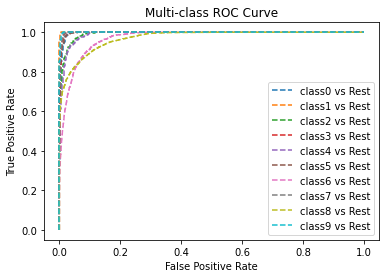

0.989201337776764


In [46]:
#ROC curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

fpr={}
tpr={}
thresh={}
n_class = 10

for i in range(n_class):
    fpr[i], tpr[i], thresh[i] = roc_curve(test_labels_list, np.array(test_outputs_list)[:,i], pos_label=i)

#print(fpr)

#plot
for i in range(n_class):
    plt.plot(fpr[i], tpr[i], linestyle = '--', label=f"class{i} vs Rest")
plt.title("Multi-class ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc = "best")
plt.show()

print(roc_auc_score(test_labels_list, test_outputs_list, multi_class='ovo', average='macro'))